In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose


import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

from scipy import spatial


In [3]:
from aislens.utils import subset_dataset_by_time
from aislens.dataprep import detrend_dim
from aislens.dataprep import detrend_dim, deseasonalize, dedraft_catchment, extrapolate_catchment_over_time
from aislens.utils import merge_catchment_files, subset_dataset_by_time, collect_directories, initialize_directories, write_crs
from aislens.config import config
import numpy as np
import xarray as xr
import geopandas as gpd

model = xr.open_dataset(config.FILE_MPASO_MODEL, chunks={config.TIME_DIM: 36})
icems = gpd.read_file(config.FILE_ICESHELFMASKS);
model = write_crs(model, config.CRS_TARGET)

model_subset = subset_dataset_by_time(model,
                                          time_dim=config.TIME_DIM,
                                          start_year=config.SORRM_START_YEAR,
                                          end_year=config.SORRM_END_YEAR,
                                          )
model_detrended = model_subset.copy()

model_detrended = model_subset.copy()
model_detrended[config.SORRM_FLUX_VAR] = detrend_dim(model_subset[config.SORRM_FLUX_VAR], dim=config.TIME_DIM, deg=1)
model_seasonality = xr.open_dataset(config.FILE_SEASONALITY, chunks={config.TIME_DIM: 36})
model_variability = xr.open_dataset(config.FILE_VARIABILITY, chunks={config.TIME_DIM: 36})
icems = icems.to_crs({'init': config.CRS_TARGET});

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
model_seasonality_ts = model_seasonality.__xarray_dataarray_variable__.mean(["x", "y"]).compute()
model_variability_ts = model_variability.timeMonthly_avg_landIceFreshwaterFlux.mean(["x", "y"]).compute()

AttributeError: 'Dataset' object has no attribute '__xarray_dataarray_variable__'

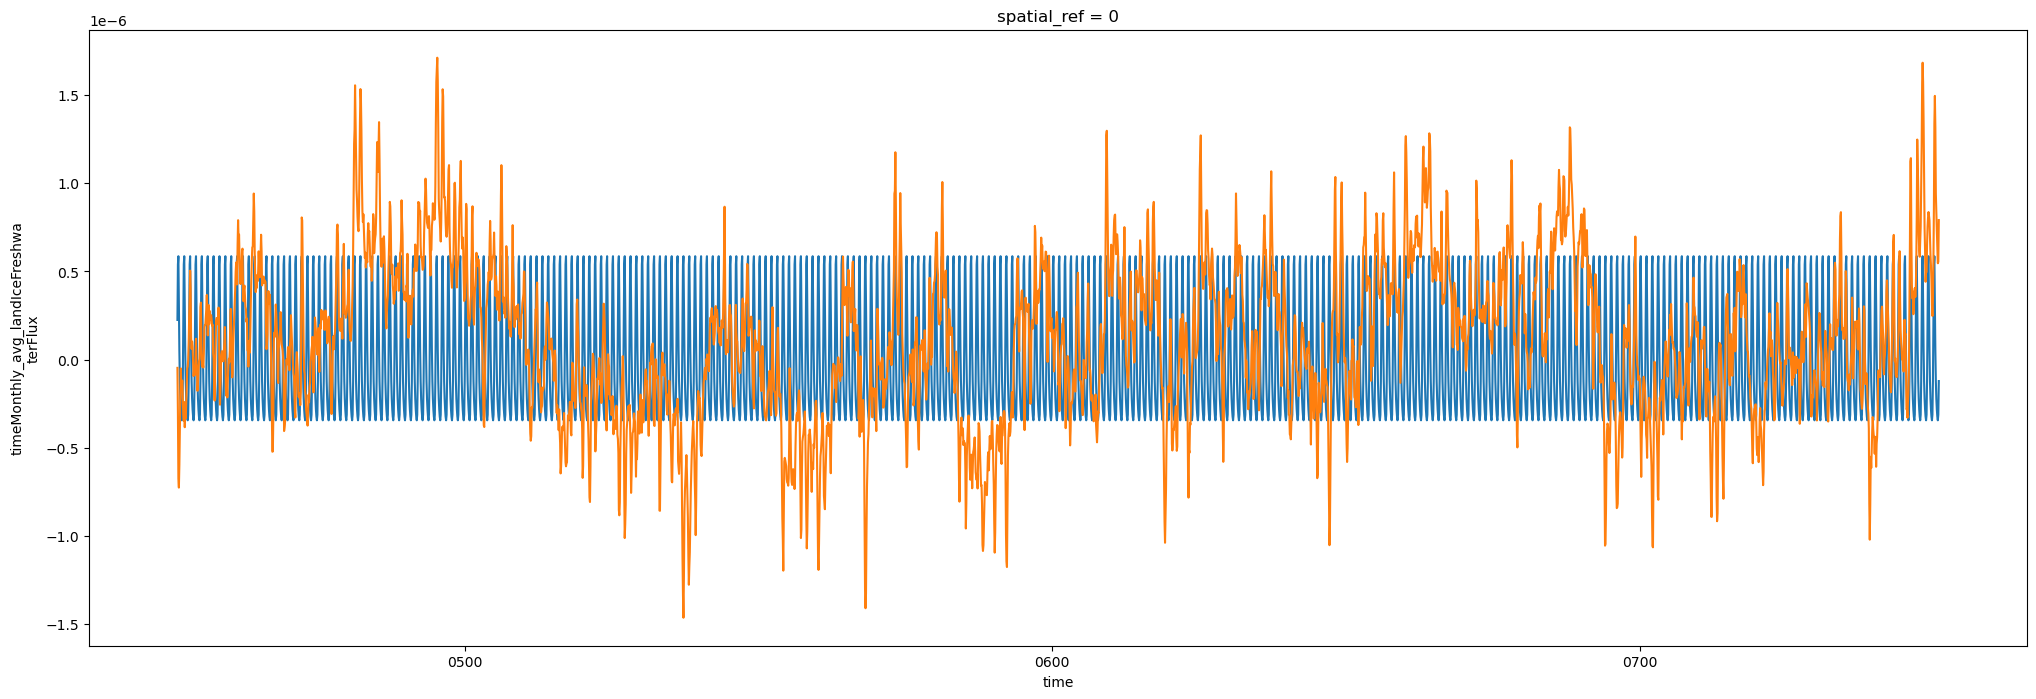

In [5]:
plt.figure(figsize=(25,8))
model_seasonality_ts.plot(label='Seasonality', color='C0')
model_variability_ts.plot(label='Variability', color='C1')
#model_subset_ts.plot(label='Original', color='C2')


In [5]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

def find_ice_shelf_index(ice_shelf_name):
    return icems[icems['name']==ice_shelf_name].index[0]

def fill_nan_with_nearest_neighbor(da):
    # Convert to numpy array
    data = da.values
    
    # Get the indices of NaN and non-NaN values
    nan_indices = np.argwhere(np.isnan(data))
    non_nan_indices = np.argwhere(~np.isnan(data))
    non_nan_values = data[~np.isnan(data)]
    
    # Create a KDTree for fast nearest-neighbor lookup
    tree = spatial.KDTree(non_nan_indices)
    
    # For each NaN value, find the nearest non-NaN value
    for nan_index in nan_indices:
        _, nearest_index = tree.query(nan_index)
        data[tuple(nan_index)] = non_nan_values[nearest_index]
    
    # Create a new DataArray with filled values
    filled_da = xr.DataArray(data, dims=da.dims, coords=da.coords, attrs=da.attrs)
    return filled_da

In [6]:
import xarray as xr
import numpy as np
from scipy import spatial
import rioxarray
import geopandas as gpd
from pathlib import Path

def fill_nan_with_nearest_neighbor_vectorized(da):
    data = da.values # extract values from DataArray
    mask = np.isnan(data) # create a mask of NaN values
    
    # Get coordinates of all points and non-NaN points
    coords = np.array(np.nonzero(np.ones_like(data))).T
    valid_coords = coords[~mask.ravel()]
    valid_values = data[~mask]
    
    # Use KDTree for efficient nearest neighbor search
    tree = spatial.cKDTree(valid_coords)
    _, indices = tree.query(coords[mask.ravel()])
    
    # Fill NaN values
    data_filled = data.copy()
    data_filled[mask] = valid_values[indices]
    
    return xr.DataArray(data_filled, dims=da.dims, coords=da.coords, attrs=da.attrs)

def process_ice_shelf(ds_data, iceShelfNum, icems):
    ice_shelf_mask = icems.loc[[iceShelfNum], 'geometry'].apply(mapping)
    ds = clip_data(ds_data, iceShelfNum)
    
    # Vectorized filling of NaN values
    ds = ds.map(fill_nan_with_nearest_neighbor_vectorized, keep_attrs=True)
    
    ds = ds.rio.clip(ice_shelf_mask, icems.crs)
    return ds

def merge_datasets(results):
    merged = xr.merge(results)
    return merged

# Assuming ds_data and merged_ds are already loaded
# ds_data = xr.open_dataset('path_to_ds_data.nc')
# merged_ds = xr.open_dataset('path_to_merged_ds.nc')

def copy_subset_data(ds_data, merged_ds):
    # Find the indices in ds_data that correspond to merged_ds coordinates
    x_indices = np.searchsorted(ds_data.x, merged_ds.x)
    y_indices = np.searchsorted(ds_data.y, merged_ds.y)

    # Get the sizes of the x and y dimensions
    x_size = ds_data.sizes['x']
    y_size = ds_data.sizes['y']

    # Create a boolean mask for the subset area in ds_data
    mask = np.zeros((y_size, x_size), dtype=bool)
    mask[np.ix_(y_indices, x_indices)] = True

    # Create a new dataset with the same structure as ds_data
    ds_result = ds_data.copy(deep=True)

    # Update the values in ds_result where the mask is True
    for var in merged_ds.data_vars:
        if var in ds_result:
            # Create a full-sized array with NaNs
            full_sized_data = np.full(ds_result[var].shape, np.nan)
            
            # Fill in the data from merged_ds
            full_sized_data[np.ix_(y_indices, x_indices)] = merged_ds[var].values
            
            # Update ds_result, preserving the original values where merged_ds doesn't have data
            ds_result[var] = xr.where(np.isnan(full_sized_data), ds_result[var], full_sized_data)

    return ds_result

In [7]:
from sklearn.neighbors import BallTree
import numpy as np

def fill_nan_with_nearest_neighbor_vectorized_balltree(da):
    data = da.values  # extract values from DataArray
    mask = np.isnan(data)  # create a mask of NaN values
    
    # Get coordinates of all points and non-NaN points
    coords = np.array(np.nonzero(np.ones_like(data))).T
    valid_coords = coords[~mask.ravel()]
    valid_values = data[~mask]
    
    # Use BallTree for efficient nearest neighbor search
    tree = BallTree(valid_coords)
    _, indices = tree.query(coords[mask.ravel()], k=1)
    
    # Fill NaN values
    data_filled = data.copy()
    data_filled[mask] = valid_values[indices.ravel()]
    
    return data_filled

def process_ice_shelf(ds_data, iceShelfNum, icems):
    ice_shelf_mask = icems.loc[[iceShelfNum], 'geometry'].apply(mapping)
    ds = clip_data(ds_data, iceShelfNum)
    
    # Vectorized filling of NaN values
    ds = ds.map(fill_nan_with_nearest_neighbor_vectorized_balltree, keep_attrs=True)
    
    ds = ds.rio.clip(ice_shelf_mask, icems.crs)
    return ds

In [6]:
model_seasonality = model_seasonality.rename_vars({'__xarray_dataarray_variable__': config.SORRM_FLUX_VAR})

In [22]:
model_varclim = model_variability + model_seasonality

In [ ]:
model_varclim_subset = model_varclim[config.SORRM_FLUX_VAR][0:4]
model_varclim_subset = model_varclim_subset.to_dataset()

In [35]:
model_variability_extrapl = extrapolate_catchment_over_time(model_variability, 
                                                            icems, config, 
                                                            config.SORRM_FLUX_VAR
                                                            )

Completed timeMonthly_avg_landIceFreshwaterFlux time step 0
Completed timeMonthly_avg_landIceFreshwaterFlux time step 1
Completed timeMonthly_avg_landIceFreshwaterFlux time step 2
Completed timeMonthly_avg_landIceFreshwaterFlux time step 3
Completed timeMonthly_avg_landIceFreshwaterFlux time step 4
Completed timeMonthly_avg_landIceFreshwaterFlux time step 5
Completed timeMonthly_avg_landIceFreshwaterFlux time step 6
Completed timeMonthly_avg_landIceFreshwaterFlux time step 7
Completed timeMonthly_avg_landIceFreshwaterFlux time step 8
Completed timeMonthly_avg_landIceFreshwaterFlux time step 9
Completed timeMonthly_avg_landIceFreshwaterFlux time step 10
Completed timeMonthly_avg_landIceFreshwaterFlux time step 11
Completed timeMonthly_avg_landIceFreshwaterFlux time step 12
Completed timeMonthly_avg_landIceFreshwaterFlux time step 13
Completed timeMonthly_avg_landIceFreshwaterFlux time step 14
Completed timeMonthly_avg_landIceFreshwaterFlux time step 15
Completed timeMonthly_avg_landIceF

In [38]:
model_variability_extrapl.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated.nc")

In [39]:
model_variability_extrapl_fillna = model_variability_extrapl.fillna(0)

In [43]:
model_variability_extrapl_fillna.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated_fillNA.nc")

In [ ]:
model_variability_extrapl_fillna_ts = model_variability_extrapl_fillna[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()
model_variability_extrapl_fillna_mean = model_variability_extrapl_fillna[config.SORRM_FLUX_VAR].mean().compute()

In [54]:
model_variability_extrapl_fillna_adj = model_variability_extrapl_fillna - model_variability_extrapl_fillna_mean
model_variability_extrapl_fillna_adj_ts = model_variability_extrapl_fillna_adj[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()

In [57]:
model_variability_extrapl_fillna_adj.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated_fillNA_adjusted-mean-zero.nc")

Text(0, 0.5, 'Freshwater Flux (kg/m2/s)')

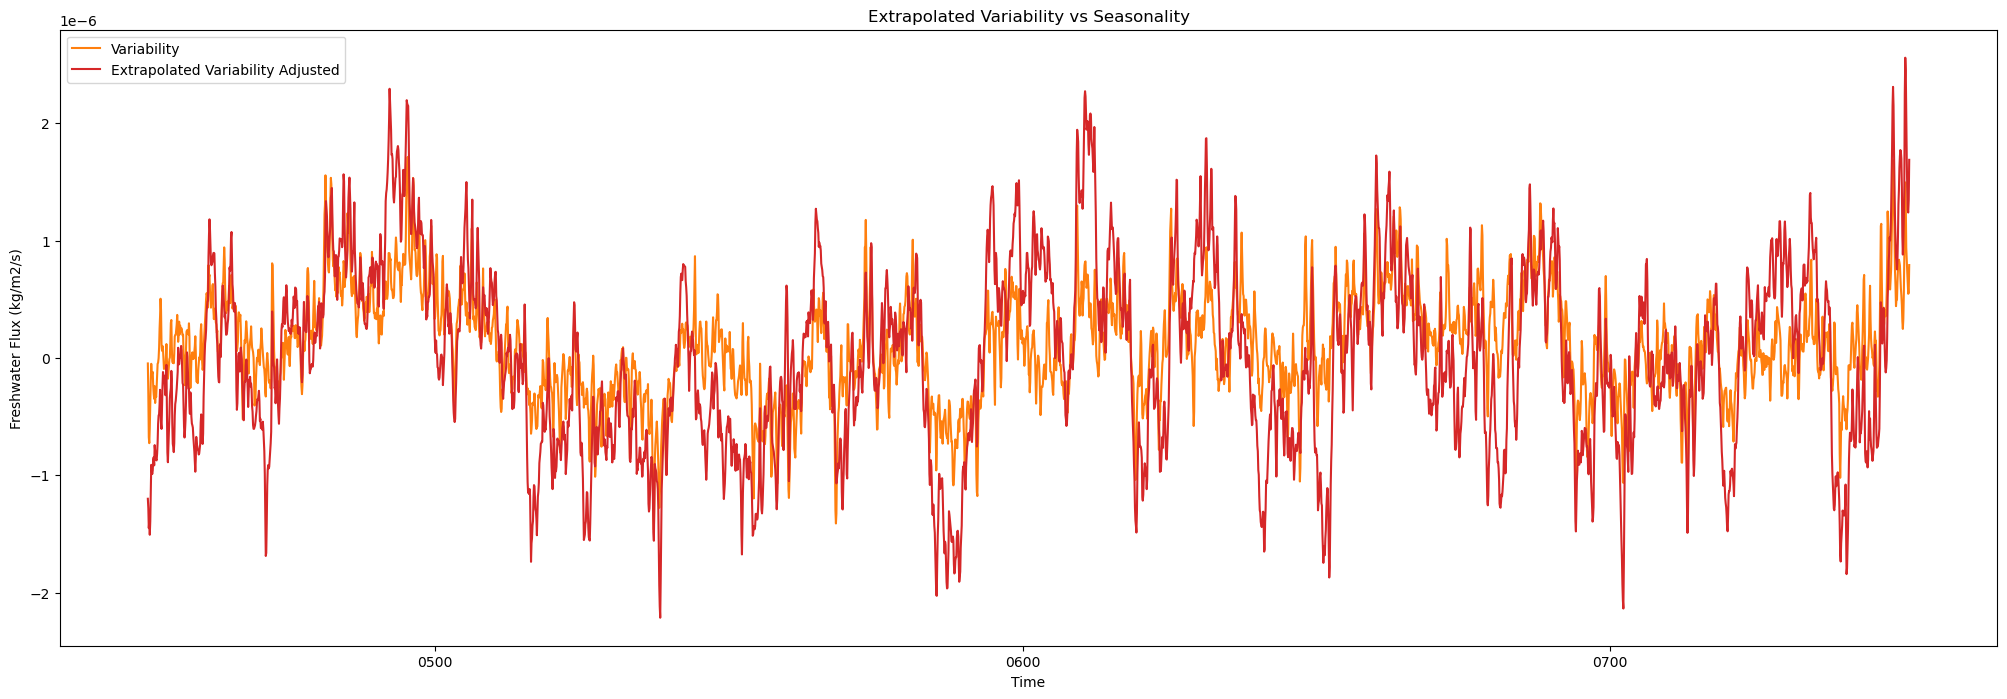

In [56]:
plt.figure(figsize=(25,8))
#model_seasonality_ts.plot(label='Seasonality', color='C0')
model_variability_ts.plot(label='Variability', color='C1')
#model_variability_extrapl_fillna_ts.plot(label='Extrapolated Variability', color='C2')
model_variability_extrapl_fillna_adj_ts.plot(label='Extrapolated Variability Adjusted', color='C3')
plt.legend()
plt.title('Extrapolated Variability vs Seasonality')
plt.xlabel('Time')
plt.ylabel('Freshwater Flux (kg/m2/s)')

In [7]:
# Select only first 12 months (along Time dimension) from model_seasonality
model_seasonality_12_months = model_seasonality.isel(Time=slice(0, 12))
model_seasonality_1_yr_extrapl = extrapolate_catchment_over_time(model_seasonality_12_months,
                                                                 icems, config, 
                                                                 config.SORRM_FLUX_VAR
                                                                 )

Completed timeMonthly_avg_landIceFreshwaterFlux time step 0
Completed timeMonthly_avg_landIceFreshwaterFlux time step 1
Completed timeMonthly_avg_landIceFreshwaterFlux time step 2
Completed timeMonthly_avg_landIceFreshwaterFlux time step 3
Completed timeMonthly_avg_landIceFreshwaterFlux time step 4
Completed timeMonthly_avg_landIceFreshwaterFlux time step 5
Completed timeMonthly_avg_landIceFreshwaterFlux time step 6
Completed timeMonthly_avg_landIceFreshwaterFlux time step 7
Completed timeMonthly_avg_landIceFreshwaterFlux time step 8
Completed timeMonthly_avg_landIceFreshwaterFlux time step 9
Completed timeMonthly_avg_landIceFreshwaterFlux time step 10
Completed timeMonthly_avg_landIceFreshwaterFlux time step 11


In [ ]:
model_seasonality_1_yr_extrapl_mean = model_seasonality_1_yr_extrapl[config.SORRM_FLUX_VAR].mean().compute()
model_seasonality_1_yr_extrapl_adj = model_seasonality_1_yr_extrapl - model_seasonality_1_yr_extrapl_mean

In [ ]:
# Repeat the dataarray in sorrmv21_ssn_extrapl to a length of Time = 3600. It now has a length of 12.
model_seasonality_extrapl = xr.concat([model_seasonality_1_yr_extrapl] * 300, dim='Time')
model_seasonality_extrapl['Time'] = model_variability.Time[:3600]

<xarray.Dataset>
Dimensions:                                (Time: 3600, x: 601, y: 601)
Coordinates:
  * Time                                   (Time) object 0451-01-16 12:00:00....
  * x                                      (x) float64 -3e+06 ... 3e+06
  * y                                      (y) float64 -3e+06 ... 3e+06
    lat                                    (y, x) float64 dask.array<chunksize=(601, 601), meta=np.ndarray>
    lon                                    (y, x) float64 dask.array<chunksize=(601, 601), meta=np.ndarray>
    spatial_ref                            int64 ...
    month                                  (Time) int64 dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    timeMonthly_avg_landIceFreshwaterFlux  (Time, y, x) float64 0.0 0.0 ... 0.0

In [10]:
model_seasonality_extrapl_ts = model_seasonality_extrapl[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()

Text(0, 0.5, 'Freshwater Flux (kg/m2/s)')

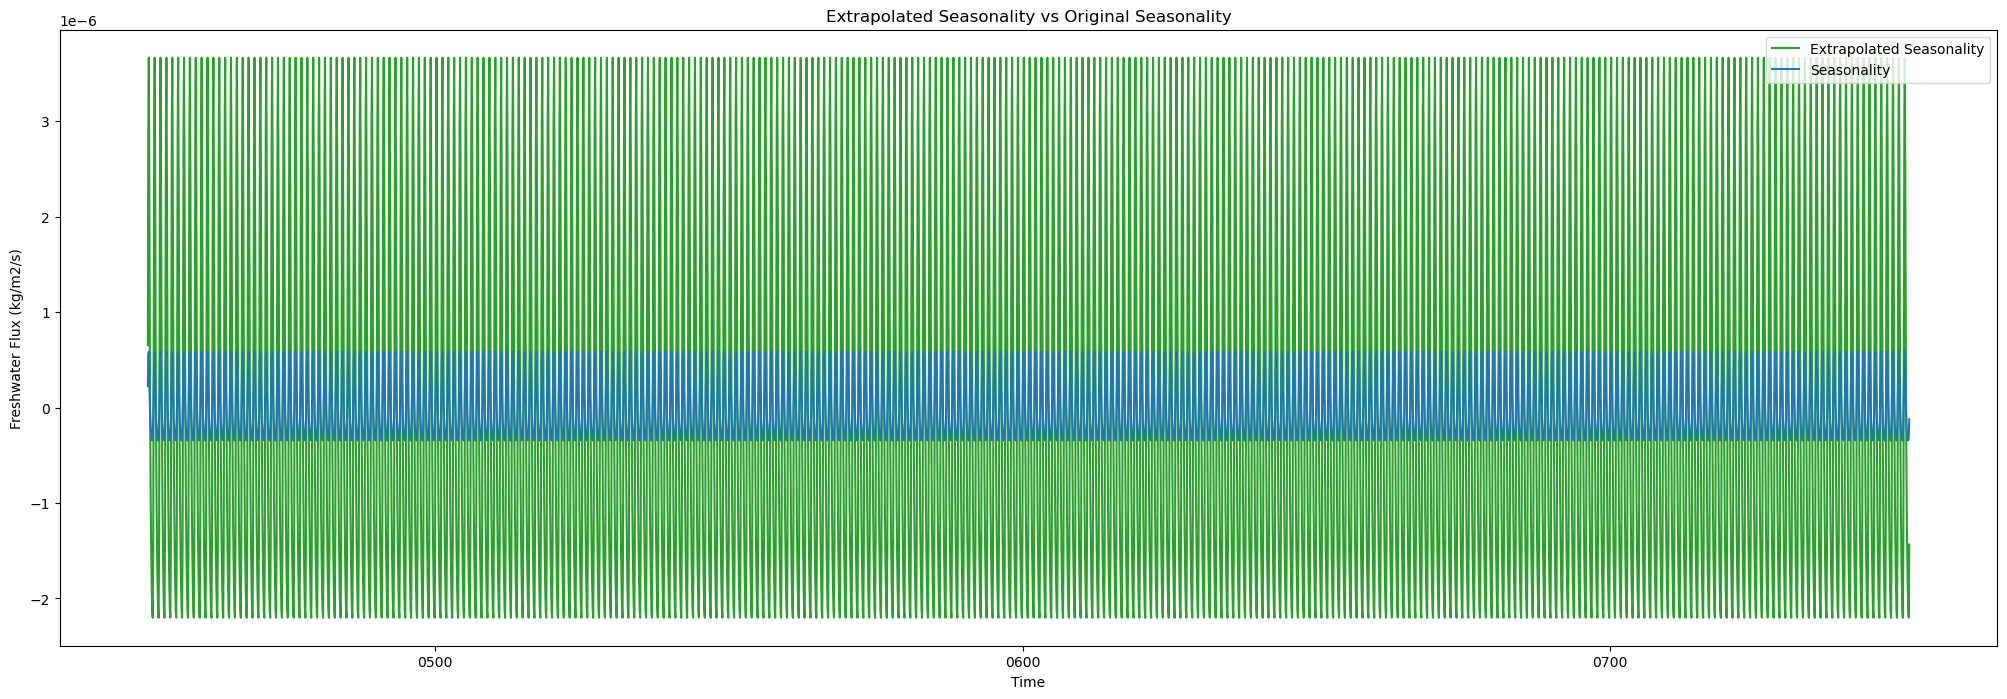

In [13]:
plt.figure(figsize=(25,8))
model_seasonality_extrapl_ts.plot(label='Extrapolated Seasonality', color='C2')
model_seasonality_ts.plot(label='Seasonality', color='C0')
plt.legend()
plt.title('Extrapolated Seasonality vs Original Seasonality')
plt.xlabel('Time')
plt.ylabel('Freshwater Flux (kg/m2/s)')

In [18]:
ssn_diff = model_seasonality - model_seasonality_extrapl

In [24]:
model_seasonality_extrapl_fillna = model_seasonality_extrapl.fillna(0)


In [25]:
model_seasonality_extrapl_fillna.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_seasonality_extrapolated_fillNA.nc")

In [27]:
model_variability_extrapl_fillna_adj = xr.open_dataset("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated_fillNA_adjusted-mean-zero.nc", chunks={config.TIME_DIM: 36})

In [28]:
model_varclim_final = model_variability_extrapl_fillna_adj + model_seasonality_extrapl_fillna

In [29]:
model_varclim_final.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_varclim_final.nc")

In [30]:
model_varclim_final_ts = model_varclim_final[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()

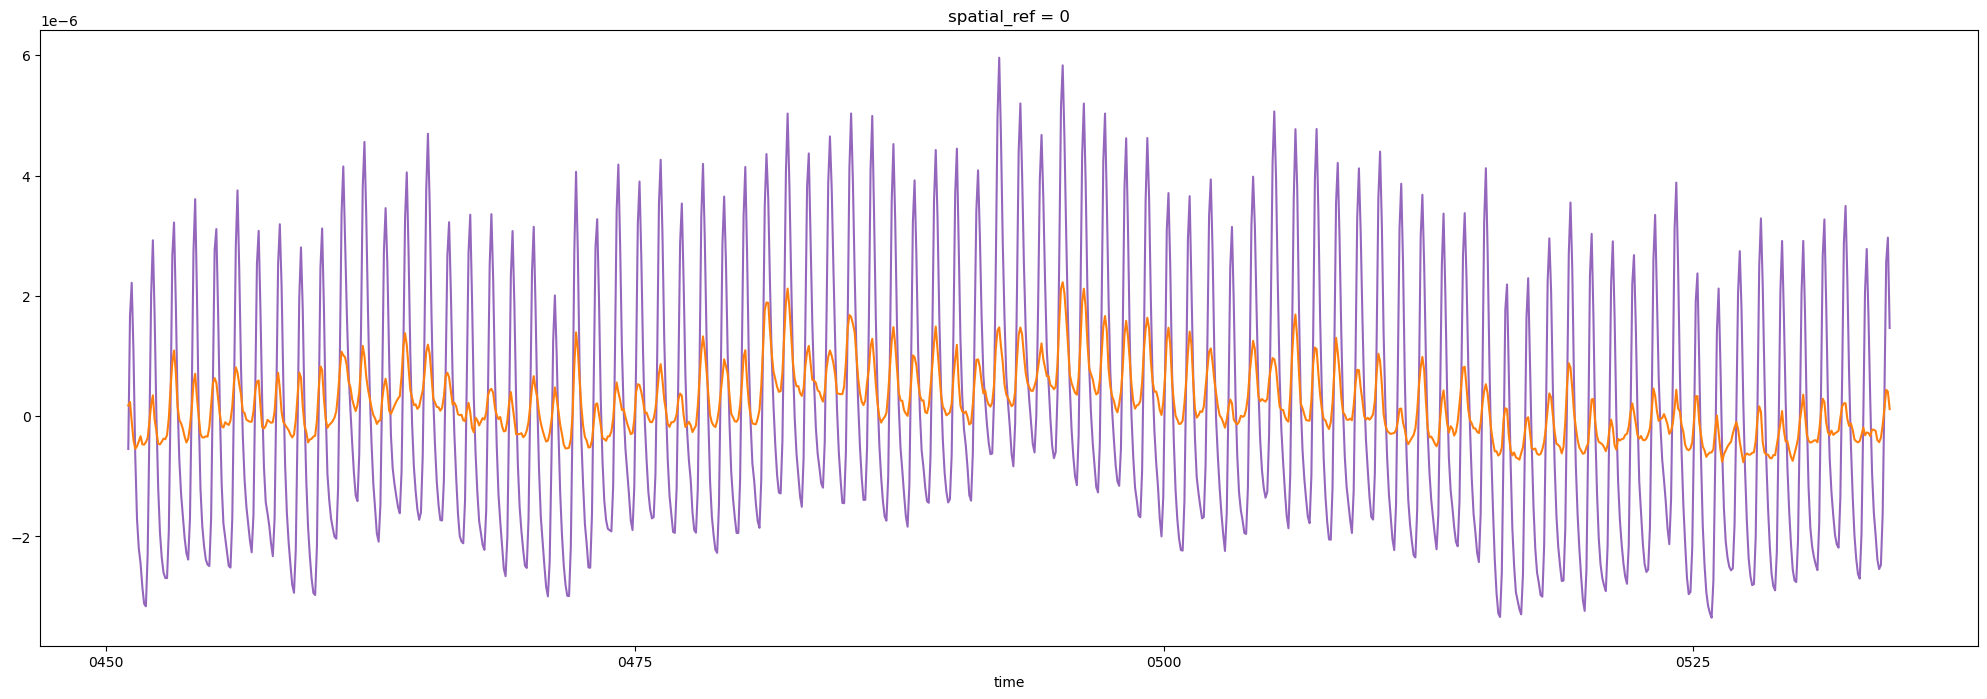

In [34]:
plt.figure(figsize=(25,8))
model_varclim_final_ts[:1000].plot(label='Final Variability + Seasonality', color='C4')
(model_variability_ts+model_seasonality_ts)[0:1000].plot(label='seasonality + Variability', color='C1')

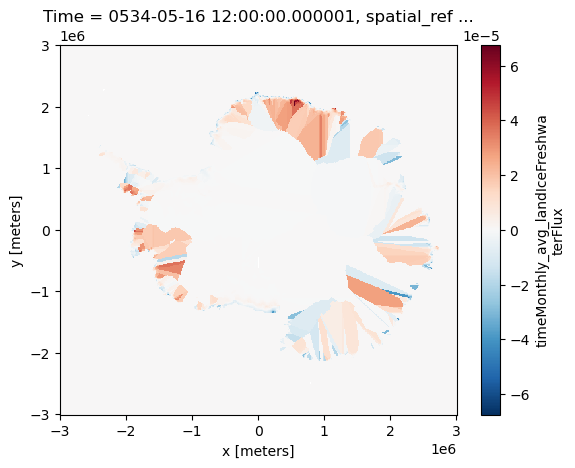

In [17]:
model_seasonality_extrapl.timeMonthly_avg_landIceFreshwaterFlux[1000].plot()

In [ ]:
model_seasonality_12_months_ts = model_seasonality_12_months[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()
model_seasonality_1_yr_extrapl_ts = model_seasonality_1_yr_extrapl[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()
model_seasonality_1_yr_extrapl_adj_ts = model_seasonality_1_yr_extrapl_adj[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()
model_seasonality_extrapl_ts = model_seasonality_extrapl[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()

Text(0, 0.5, 'Freshwater Flux (kg/m2/s)')

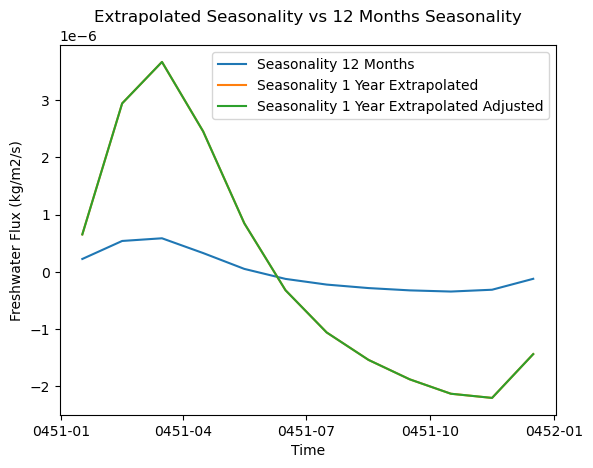

In [80]:
model_seasonality_12_months_ts.plot(label='Seasonality 12 Months', color='C0')
model_seasonality_1_yr_extrapl_ts.plot(label='Seasonality 1 Year Extrapolated', color='C1')
model_seasonality_1_yr_extrapl_adj_ts.plot(label='Seasonality 1 Year Extrapolated Adjusted', color='C2')
plt.legend()
plt.title('Extrapolated Seasonality vs 12 Months Seasonality')
plt.xlabel('Time')
plt.ylabel('Freshwater Flux (kg/m2/s)')


In [59]:
# Extrapolate seasonality to the entire ice sheet for just the first 12 time steps, which is 1 year.
model_seasonality_extrapl = model_seasonality[:12].interp_like(model_variability_extrapl[:12], method='nearest')

ValueError: Unsupported key-type <class 'slice'>

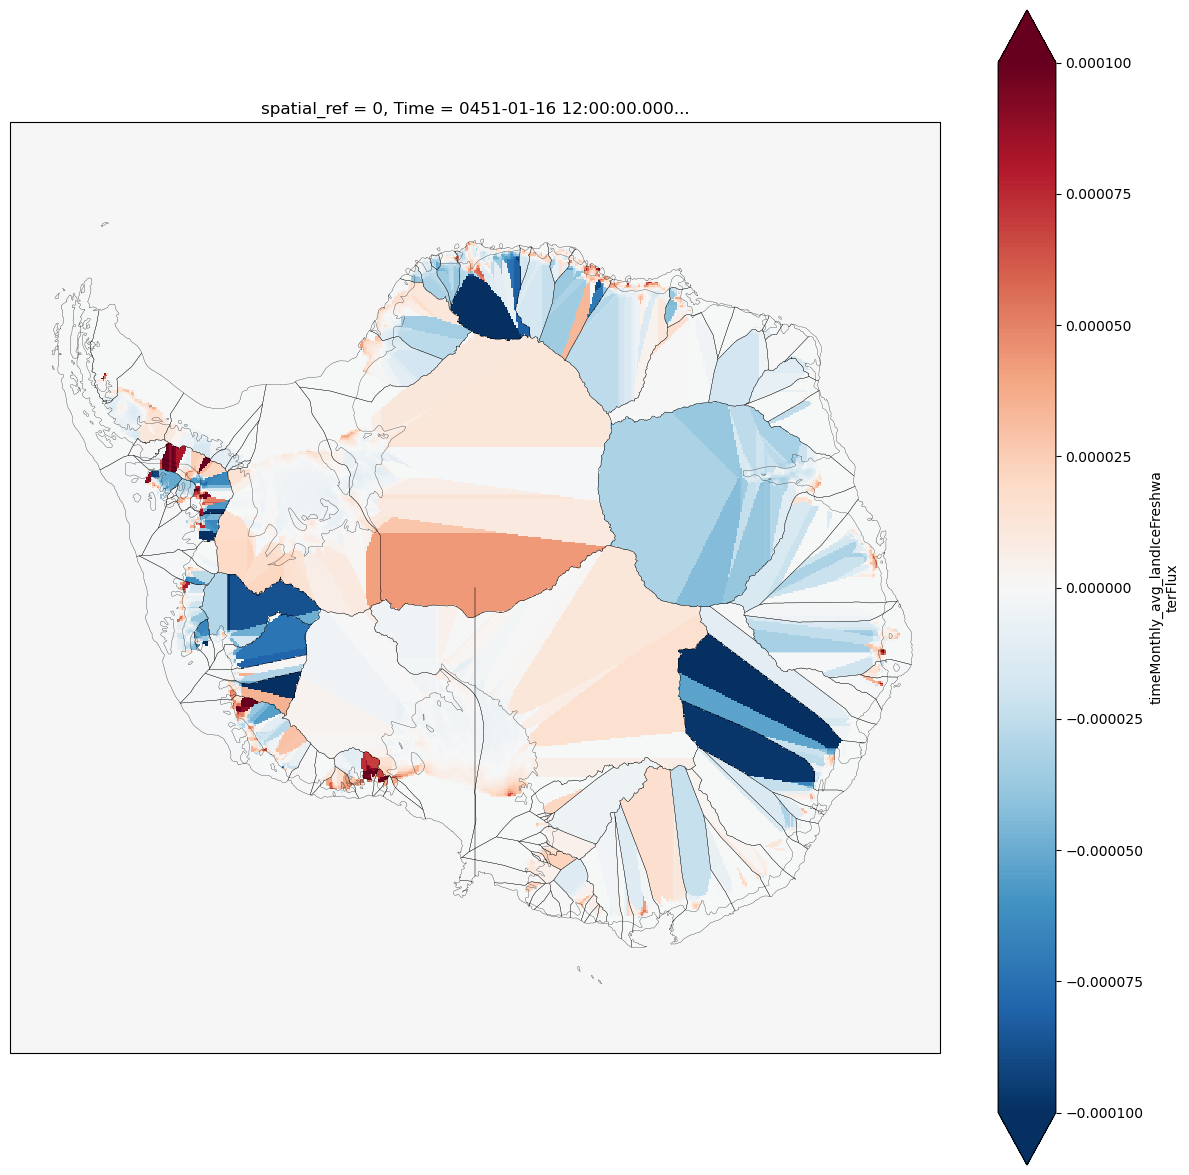

In [66]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

# icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


# ax1.patch.set_facecolor(color='lightsteelblue')
# ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)
model_variability_extrapl_fillna.timeMonthly_avg_landIceFreshwaterFlux[0].plot(vmin=-0.0001, vmax=0.0001, cmap='RdBu_r')

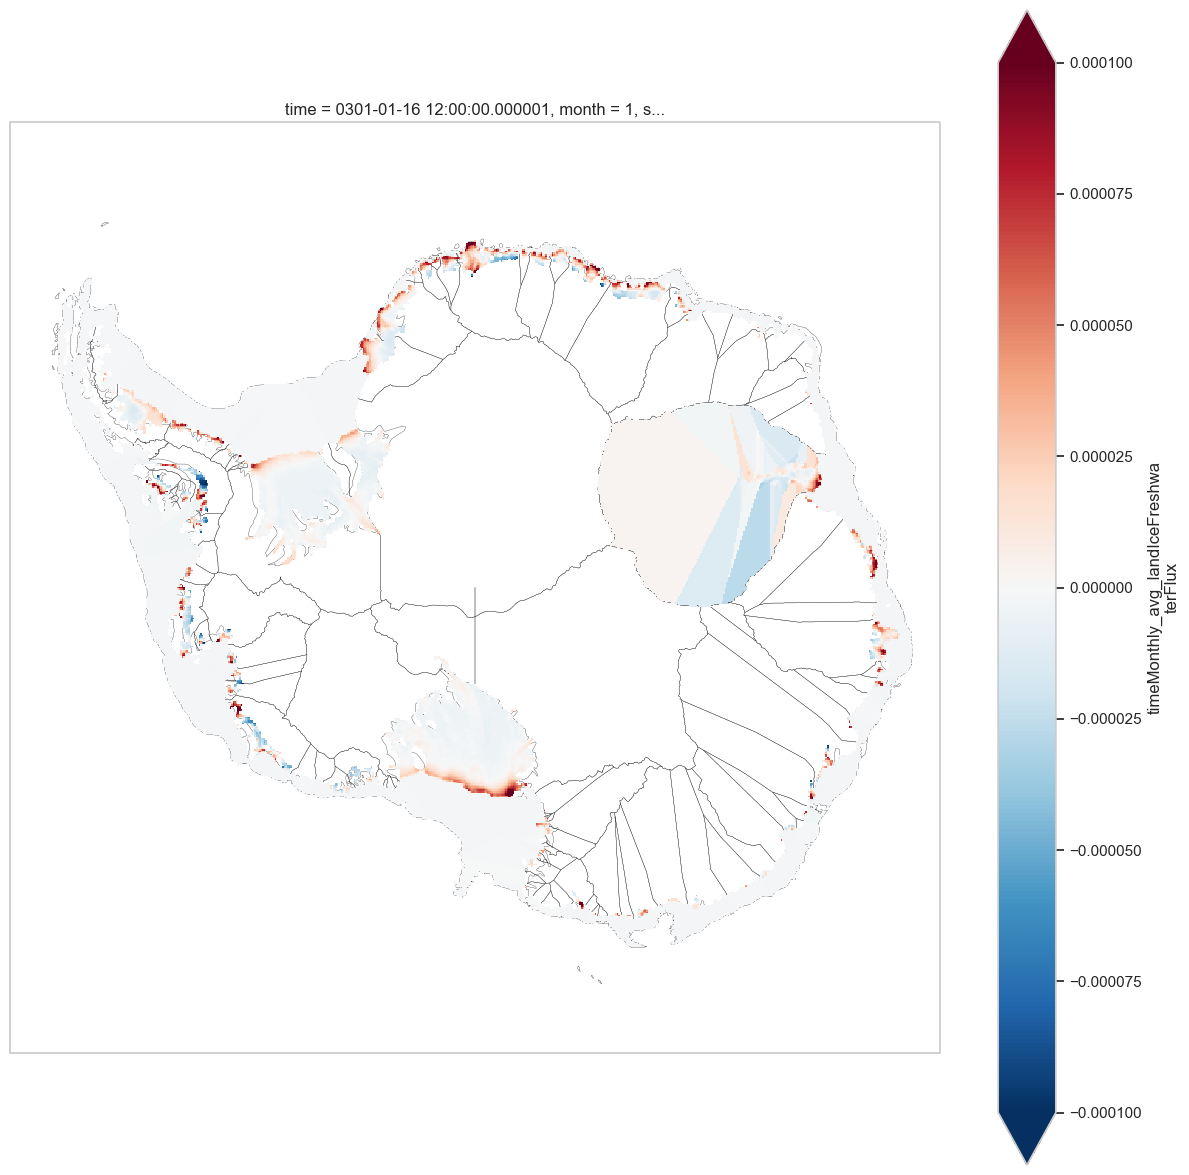

In [67]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

# icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


# ax1.patch.set_facecolor(color='lightsteelblue')
# ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)
varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[0].plot(ax=ax1, zorder=8, vmax=0.0001, vmin=-0.0001, cmap='RdBu_r')

In [8]:
varSORRM

<xarray.Dataset>
Dimensions:                        (y: 601, x: 601, Time: 7200)
Coordinates:
  * y                              (y) float64 -3e+06 -2.99e+06 ... 3e+06
  * x                              (x) float64 -3e+06 -2.99e+06 ... 3e+06
  * Time                           (Time) object 0301-01-16 12:00:00.000001 ....
    month                          (Time) int64 dask.array<chunksize=(7200,), meta=np.ndarray>
    spatial_ref                    int64 ...
Data variables:
    __xarray_dataarray_variable__  (Time, y, x) float64 dask.array<chunksize=(7200, 601, 601), meta=np.ndarray>

In [13]:
# Create a dummy xarray dataArray in the shape of varSORRM.timeMonthly_avg_landIceFreshwaterFlux

varSORRM_extrapl_array = np.empty(varSORRM.__xarray_dataarray_variable__.shape)
varSORRM_extrapl_array[:] = 0 # np.nan

varSORRM_extrapl = xr.DataArray(varSORRM_extrapl_array, coords=varSORRM.__xarray_dataarray_variable__.coords, dims = varSORRM.__xarray_dataarray_variable__.dims, attrs=varSORRM.__xarray_dataarray_variable__.attrs)
varSORRM_extrapl = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(varSORRM_extrapl)))

for t in range(len(varSORRM.Time)):  # Change to range(len(varSORRM.time)) for full processing
    ds_data = varSORRM.isel(Time=t)#.rename({'x1': 'x', 'y1': 'y'})
    
    # Process all ice shelves in parallel
    ice_shelf_range = range(33, 133)
    results = [process_ice_shelf(ds_data, iceShelfNum, icems) for iceShelfNum in ice_shelf_range]

    merged_ds = merge_datasets(results)
    result_ds = copy_subset_data(ds_data, merged_ds)

    varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[t] = result_ds.__xarray_dataarray_variable__
    del ds_data, results, merged_ds, result_ds
    print(f"Completed time step {t}")


varSORRM_extrapl = varSORRM_extrapl.fillna(0)
# Save the updated varSORRM
varSORRM_extrapl.to_netcdf(main_dir / DIR_processed / 'sorrm/SORRMv21_variability_600y_resized_NNextrapl_NaN.nc')
print("Processing complete. Updated dataset saved.")

Completed time step 0
Completed time step 1
Completed time step 2
Completed time step 3
Completed time step 4
Completed time step 5
Completed time step 6
Completed time step 7
Completed time step 8
Completed time step 9
Completed time step 10
Completed time step 11
Completed time step 12
Completed time step 13
Completed time step 14
Completed time step 15
Completed time step 16
Completed time step 17
Completed time step 18
Completed time step 19
Completed time step 20
Completed time step 21
Completed time step 22
Completed time step 23
Completed time step 24
Completed time step 25
Completed time step 26
Completed time step 27
Completed time step 28
Completed time step 29
Completed time step 30
Completed time step 31
Completed time step 32
Completed time step 33
Completed time step 34
Completed time step 35
Completed time step 36
Completed time step 37
Completed time step 38
Completed time step 39
Completed time step 40
Completed time step 41
Completed time step 42
Completed time step 4

In [15]:
sorrmv21_ssn_1yr.shape

(12, 601, 601)

In [31]:
sorrmv21_ssn_1yr_ds.rio.write_crs("epsg:3031", inplace=True);

In [34]:
# Create a dummy xarray dataArray in the shape of varSORRM.timeMonthly_avg_landIceFreshwaterFlux

sorrmv21_ssn_extrapl_array = np.empty(sorrmv21_ssn_1yr.shape)
sorrmv21_ssn_extrapl_array[:] = np.nan

sorrmv21_ssn_1yr_ds

sorrmv21_ssn_extrapl = xr.DataArray(sorrmv21_ssn_extrapl_array, coords=sorrmv21_ssn_1yr_ds.coords, dims = sorrmv21_ssn_1yr_ds.dims, attrs=sorrmv21_ssn_1yr_ds.attrs)
sorrmv21_ssn_extrapl = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(sorrmv21_ssn_extrapl)))

for t in range(len(sorrmv21_ssn_1yr_ds.Time)):  # Change to range(len(varSORRM.time)) for full processing
    ds_data = sorrmv21_ssn_1yr_ds.isel(Time=t)#.rename({'x1': 'x', 'y1': 'y'})
    
    # Process all ice shelves in parallel
    ice_shelf_range = range(33, 133)
    results = [process_ice_shelf(ds_data, iceShelfNum, icems) for iceShelfNum in ice_shelf_range]

    merged_ds = merge_datasets(results)
    result_ds = copy_subset_data(ds_data, merged_ds)

    sorrmv21_ssn_extrapl.timeMonthly_avg_landIceFreshwaterFlux[t] = result_ds.ssn
    del ds_data, results, merged_ds, result_ds
    print(f"Completed time step {t}")


sorrmv21_ssn_extrapl = sorrmv21_ssn_extrapl.fillna(0)
# Save the updated varSORRM
#sorrmv21_ssn_extrapl.to_netcdf(main_dir / DIR_processed / 'sorrm/SORRMv21_variability_600y_resized_NNextrapl_NaN.nc')
#print("Processing complete. Updated dataset saved.")

Completed time step 0
Completed time step 1
Completed time step 2
Completed time step 3
Completed time step 4
Completed time step 5
Completed time step 6
Completed time step 7
Completed time step 8
Completed time step 9
Completed time step 10
Completed time step 11


In [ ]:
# Repeat the dataarray in sorrmv21_ssn_extrapl to a length of Time = 3600. It now has a length of 12.
sorrmv21_ssn_extrapl_repeated = xr.concat([sorrmv21_ssn_extrapl] * 300, dim='Time')
sorrmv21_ssn_extrapl_repeated['Time'] = varSORRM.Time[:3600]

In [69]:
sorrmv21_ssn_extrapl_repeated_ts = sorrmv21_ssn_extrapl_repeated.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()

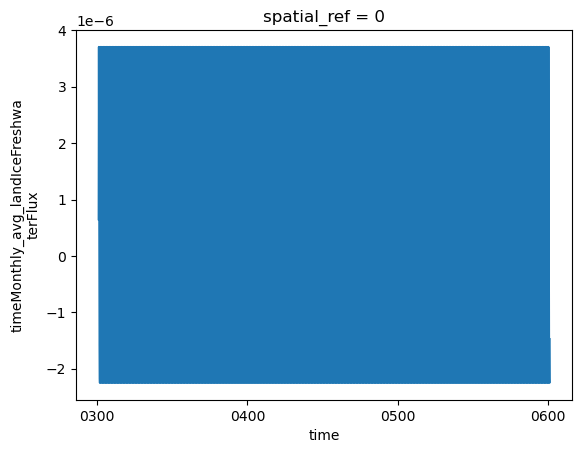

In [72]:
sorrmv21_ssn_extrapl_repeated_ts.plot()

In [78]:
sorrmv21_ssn_extrapl_repeated

# Add an attribute to sorrmv21_ssn_extrapl_repeated
sorrmv21_ssn_extrapl_repeated.attrs['description'] = "Seasonality of ice shelf meltwater flux from the SORRMv2.1 model, extrapolated to the entire ice sheet."

In [80]:
sorrmv21_ssn_extrapl_repeated.to_netcdf(main_dir / DIR_processed / 'sorrm/SORRMv21_seasonality_300y_NNextrapl_NaN.nc')

NameError: name 'varSORRM_extrapl' is not defined

In [18]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
icv_vmin = np.nanquantile(varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux.values, 0.01)
icv_vmax = np.nanquantile(varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux.values, 0.99)

In [16]:
icv_vmax

5.7958516732482225e-05

In [17]:
# Find the max of abs values between icv_vmin and icv_vmax
iceShelves

In [19]:
absmax = max(abs(icv_vmin), abs(icv_vmax))

In [20]:
absmin = min(abs(icv_vmin), abs(icv_vmax))

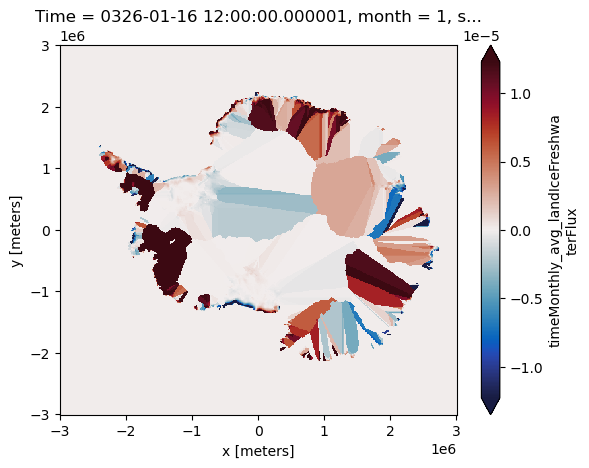

In [28]:
varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[300].plot(vmin=-absmax/2, vmax=absmax/2, cmap=cmocean.cm.balance)

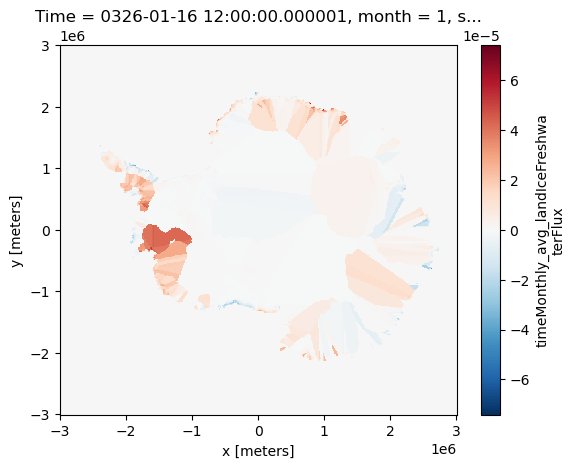

In [22]:
varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[300].plot()

<Figure size 640x480 with 0 Axes>

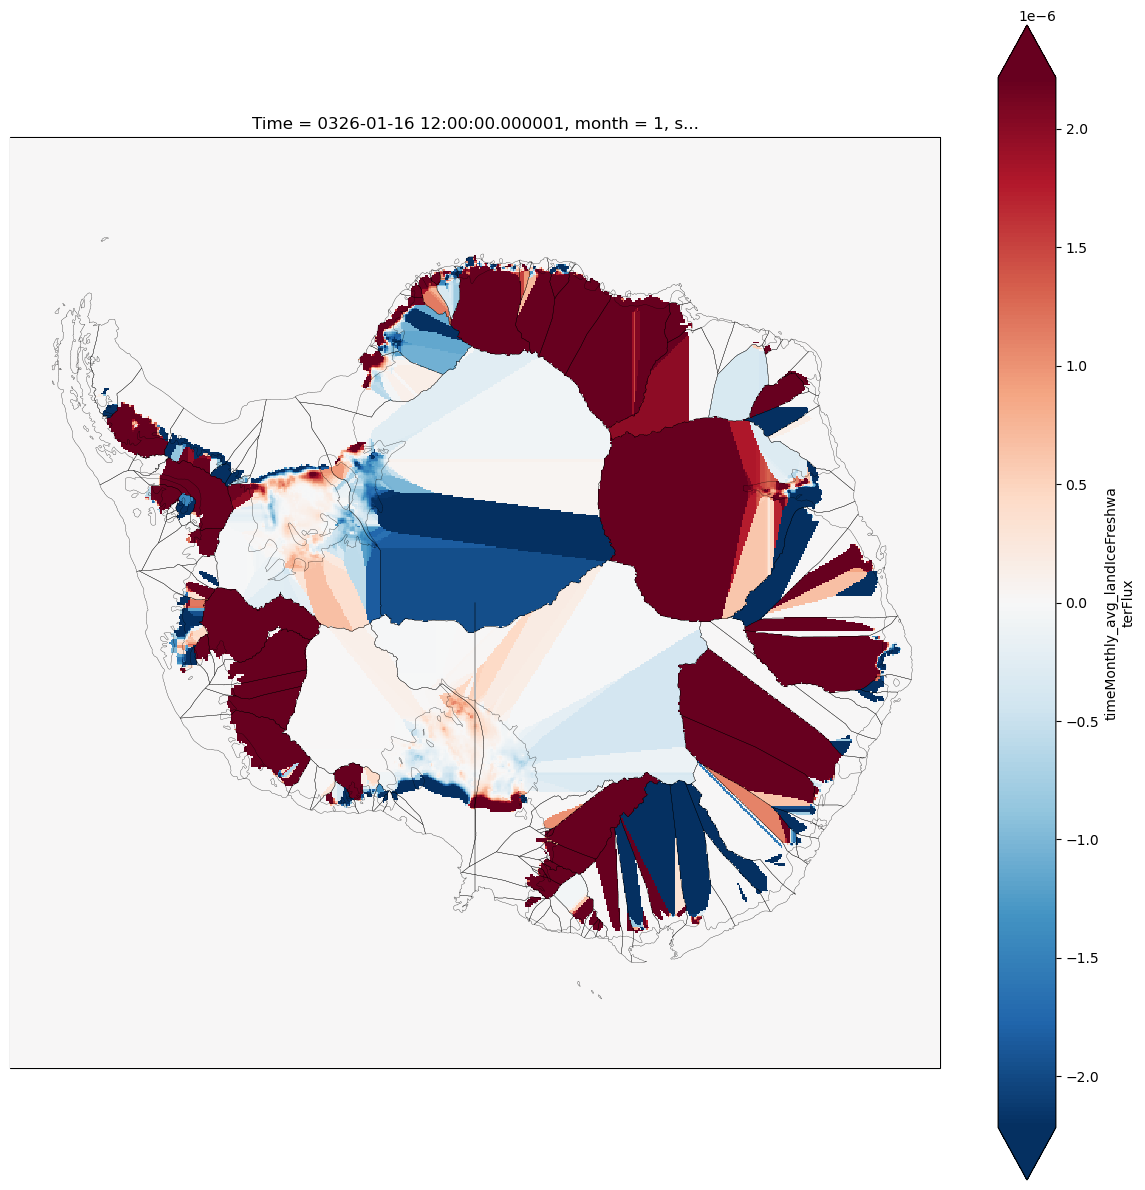

In [46]:
# sns.set_theme(style="whitegrid")

plt.clf()
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[300].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6, vmin=-absmin/10, vmax=absmin/10)
ax1.coastlines(lw=0.2, zorder=8)
# varSORRM.timeMonthly_avg_landIceFreshwaterFlux[10].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6)
#plt.savefig('ICV_extrapl_t-{}.png'.format(10), dpi=300)

In [47]:
varSORRM_extrapl_ts = varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y'])

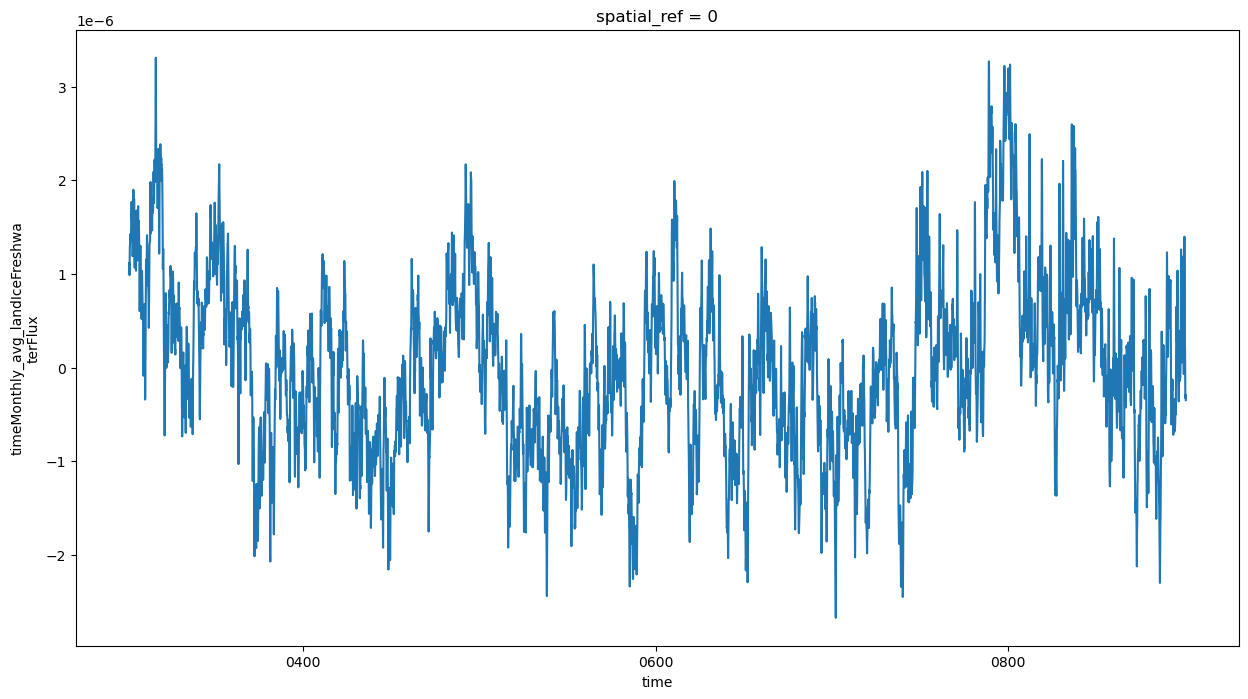

In [49]:
plt.figure(figsize=(15,8))
varSORRM_extrapl_ts.plot()

<Figure size 640x480 with 0 Axes>

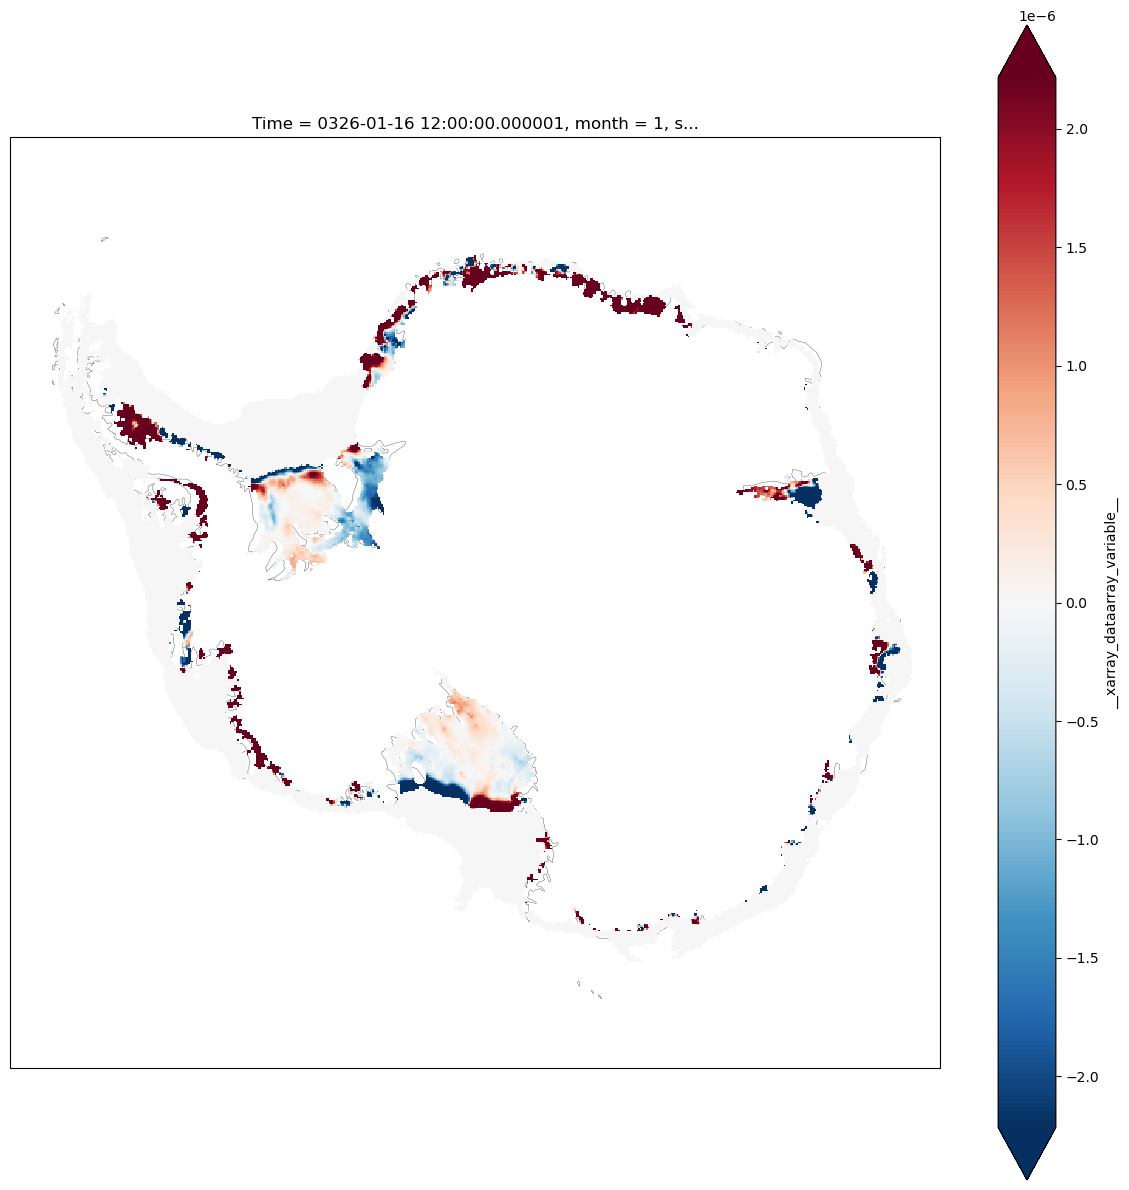

In [39]:
# sns.set_theme(style="whitegrid")

plt.clf()
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
#icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)
varSORRM.__xarray_dataarray_variable__[300].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6, vmin=-absmin/10, vmax=absmin/10)
# varSORRM.timeMonthly_avg_landIceFreshwaterFlux[10].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6)
#plt.savefig('ICV_extrapl_t-{}.png'.format(10), dpi=300)

In [32]:
varSORRM_extrapl_noNaN = varSORRM_extrapl.fillna(0)

In [35]:
varSORRM_extrapl_noNaN.to_netcdf(main_dir / DIR_processed / 'SORRMv21_variability_300y_NNextrapl_noNaN.nc')

In [1]:
# sns.set_theme(style="whitegrid")

plt.clf()
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


ax1.patch.set_facecolor(color='lightsteelblue')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)
varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[1000].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6, vmin=-absmax, vmax=absmax)
# varSORRM.timeMonthly_avg_landIceFreshwaterFlux[10].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6)
plt.savefig('ICV_extrapl_t-{}.png'.format(10), dpi=300)

NameError: name 'plt' is not defined

In [ ]:

sns.set_theme(style="whitegrid")

for t in range(len(varSORRM.time)):
    plt.clf()
    plt.figure(figsize=(15,15))
    ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

    # icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
    # icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


    #ax1.patch.set_facecolor(color='lightsteelblue')
    #ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
    ax1.coastlines(lw=0.2)
    varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[t].plot(ax=ax1, cmap="RdBu_r", vmin=icv_vmin, vmax=icv_vmax, add_colorbar=True)
    # savefig with 4 digits for the time step
    plt.savefig('ICV_extrapl_t-{:04d}.png'.format(t), dpi=300)
    plt.close()

In [201]:
# Create a dummy xarray dataArray in the shape of varSORRM.timeMonthly_avg_landIceFreshwaterFlux


for t in range(len(varSORRM.time)):  # Change to range(len(varSORRM.time)) for full processing
    ds_data = varSORRM.isel(time=t).rename({'x1': 'x', 'y1': 'y'})
    
    # Process all ice shelves in parallel
    ice_shelf_range = range(33, 133)
    results = [process_ice_shelf(ds_data, iceShelfNum, icems) for iceShelfNum in ice_shelf_range]

    merged_ds = merge_datasets(results)
    result_ds = copy_subset_data(ds_data, merged_ds)

    # Replace the values of varSORRM with the values from result_ds
    for var in result_ds.data_vars:
        if var in varSORRM:
            # Create a boolean mask for non-NaN values in result_ds
            update_mask = ~np.isnan(result_ds[var].values)
            
            # Update varSORRM where update_mask is True
            varSORRM[var].values[t, update_mask] = result_ds[var].values[update_mask]
    print(f"Completed time step {t}")

# Save the updated varSORRM
varSORRM.to_netcdf('path_to_updated_varSORRM.nc')
print("Processing complete. Updated dataset saved.")

Completed time step 0


In [ ]:
for t in range(1):# len(varSORRM.time)):
    ds_data = varSORRM.isel(time=t)
    ds_data = ds_data.rename({'x1':'x','y1':'y'})
    # Create a xarray dataArray in the shape of ds_data
    
    # ds = ds.timeMonthly_avg_landIceFreshwaterFlux
    for iceShelfNum in range(34,133):
        ds = clip_data(ds_data, iceShelfNum)
        ice_shelf_mask = icems.loc[[iceShelfNum],'geometry'].apply(mapping)
        # Process each variable in the dataset
        for var_name, da in ds.data_vars.items():
            # Check if the variable has the correct dimensions (x, y, Time)
            if set(da.dims) == {'x', 'y'}:
                # Fill NaN values
                ds[var_name] = fill_nan_with_nearest_neighbor(da)
        # Fill values from ds to the same x,y coordinates in ds_data
        
        ds = ds.rio.clip(ice_shelf_mask,icems.crs)
        ds.to_netcdf(main_dir / DIR_interim / 'ICV_300y_extrapolate/SORRMv21_ICV_t{}_iceShelf{}.nc'.format(t, iceShelfNum))
        del ds, ice_shelf_mask
        print("filled data for time: {}, ice shelf: {}".format(t, iceShelfNum))
    del ds_data